In [1]:
#imports

import tensorflow as tf
import numpy as np
import pandas as pd
import os
import glob
import cv2
import re
import keras
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Conv2D,Dense,Dropout,Flatten,MaxPooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.utils import np_utils
from PIL import ImageFile 
import matplotlib.pyplot as plt
from keras.preprocessing import image                  
from tqdm import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_curve, auc
from matplotlib.colors import ListedColormap
import seaborn as sns
import warnings; warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report


# **Importing data**

In [2]:
data_dir = "../input/field-dataset/field"

root, dirs, files = next(os.walk(data_dir), ([],[],[]))
dirs.sort()
print(len(dirs))

184


# **Resising the image**

In [3]:
def resize(fl, img_height, img_width):
    img = cv2.imread(fl)
    resized = cv2.resize(img, (img_height, img_width))
    return resized

# Making  data

In [4]:
def get_data():
    X = []
    y = []
    classes = []
    dir_names = []
    
    for dir_name in dirs[:30]:
        class_name = dir_name.replace('_','')
        classes.append(class_name)
        
        dir_names.append(dir_name)
        
        path = os.path.join(data_dir,dir_name,'*.jpg')
        images = glob.glob(path)
        
        for fl in images:
            flbase = os.path.basename(fl)
            img = resize(fl, 64, 64)
            X.append(img)
            y.append(class_name)
            
    return X, y, classes,dir_names

In [5]:
X, y, classes,dir_names = get_data()

In [7]:
X = np.array(X)


print('Shape of X is',len(X))
print('Shape of Y is',len(y))

Shape of X is 1064
Shape of Y is 1064


In [8]:
class_dict={}
for i,class_name in enumerate(classes):
    class_dict[i] = class_name
    

print(len(class_dict))
    

30


# Sample images

Text(0.5, 1.0, '')

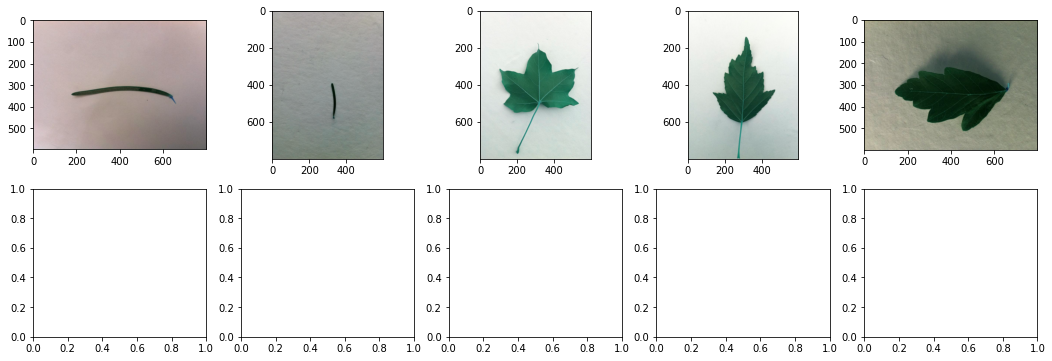

In [9]:
# Sample Image for each class
img_array=[]
for i in dir_names:
    path = os.path.join(data_dir, i)
    
    for img in os.listdir(path):
        imgs = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
        img_array.append(imgs)
        break

f, axarr = plt.subplots(2,5,figsize=(18,6))  

axarr[0,0].imshow(img_array[0])
axarr[0,0].set_title(class_dict.get('0')) 

axarr[0,1].imshow(img_array[1])
axarr[0,1].set_title(class_dict.get('1')) 

axarr[0,2].imshow(img_array[2])
axarr[0,2].set_title(class_dict.get('2')) 

axarr[0,3].imshow(img_array[3])
axarr[0,3].set_title(class_dict.get('3')) 

axarr[0,4].imshow(img_array[4])
axarr[0,4].set_title(class_dict.get('4')) 

#axarr[1,0].imshow(img_array[5])
#axarr[1,0].set_title(class_dict.get('5')) 

#axarr[1,1].imshow(img_array[6])
#axarr[1,1].set_title(class_dict.get('6')) 

#axarr[1,2].imshow(img_array[7])
#axarr[1,2].set_title(class_dict.get('7')) 

#axarr[1,3].imshow(img_array[8])
#axarr[1,3].set_title(class_dict.get('8')) 

#axarr[1,4].imshow(img_array[9])
#axarr[1,4].set_title(class_dict.get('9'))

# Transforming labels to numerical using label encoder

In [10]:
#y = np_utils.to_categorical(y, num_classes=184,dtype ="int32")


from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y)
y_encoded = le.transform(y)

# Splitting into training and test data

In [11]:
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y_encoded,test_size = 0.3,stratify=y_encoded,random_state=42)

In [12]:
y_train_one_hot = np_utils.to_categorical(ytrain)
y_test_one_hot = np_utils.to_categorical(ytest)

In [13]:
Xtrain[5].shape

(64, 64, 3)

# Downloading ResNet50

In [14]:
modelResNet = ResNet50(include_top=False,  weights='imagenet',)


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

94781440/94765736 [==============================] - 3s 0us/step


In [15]:
for layer in modelResNet.layers:
    layer.trainable = False

# Extracting training features

In [16]:
%%time

feature_extractor_train=modelResNet.predict(Xtrain)

2021-12-07 03:50:00.561773: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


CPU times: user 20.6 s, sys: 426 ms, total: 21 s
Wall time: 11.7 s


# Extracting testing features

In [17]:
%%time

feature_extractor_test=modelResNet.predict(Xtest)

CPU times: user 9.44 s, sys: 149 ms, total: 9.59 s
Wall time: 3.68 s


In [18]:
training_features = feature_extractor_train.reshape(feature_extractor_train.shape[0], -1)
testing_features = feature_extractor_test.reshape(feature_extractor_test.shape[0], -1)

In [19]:
xtrain = training_features
xtest = testing_features

print(xtrain.shape,xtest.shape,ytrain.shape,ytest.shape)

(744, 8192) (320, 8192) (744,) (320,)


# KNN

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 30) }
knn_gridcv = GridSearchCV(clf_knn, param_grid ,cv=10, refit = True,n_jobs= -1)
knn_gridcv.fit(xtrain,ytrain)
knn_gridcv.best_params_

{'n_neighbors': 1}

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
grid_predictin_random= knn_gridcv.predict(xtest)

In [29]:
grid_predictin_random   = le.inverse_transform(grid_predictin_random)
ytest   = le.inverse_transform(ytest)

In [34]:
ytrain   = le.inverse_transform(ytrain)

# Classification report for KNN

In [30]:
print(classification_report(ytest,grid_predictin_random))

                         precision    recall  f1-score   support

          abiesconcolor       1.00      1.00      1.00        15
      abiesnordmanniana       1.00      1.00      1.00        11
          acercampestre       0.77      0.91      0.83        11
            acerginnala       0.64      1.00      0.78         9
            acergriseum       0.85      0.79      0.81        14
            acernegundo       0.88      0.70      0.78        10
           acerpalmatum       0.96      0.93      0.95        28
      acerpensylvanicum       1.00      0.73      0.84        11
        acerplatanoides       1.00      0.50      0.67         6
     acerpseudoplatanus       0.57      1.00      0.73         4
             acerrubrum       0.73      0.79      0.76        14
        acersaccharinum       0.85      0.92      0.88        12
          acersaccharum       0.83      0.71      0.77         7
          aesculusflava       0.75      0.75      0.75         4
         aesculusglabra 

# Accuracy VS n_neighbors

Text(0, 0.5, 'Cross-validated accuracy')

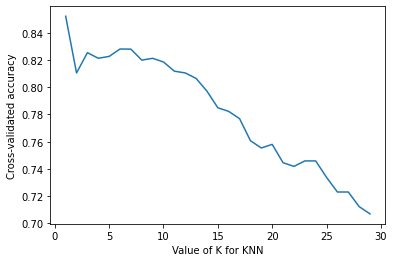

In [23]:
k_range = range(1, 30)
k_scores = knn_gridcv.cv_results_['mean_test_score']
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-validated accuracy')

# ROC For KNN

In [24]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.predict_proba(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()
    plt.savefig('resnet_knn_roc.png')


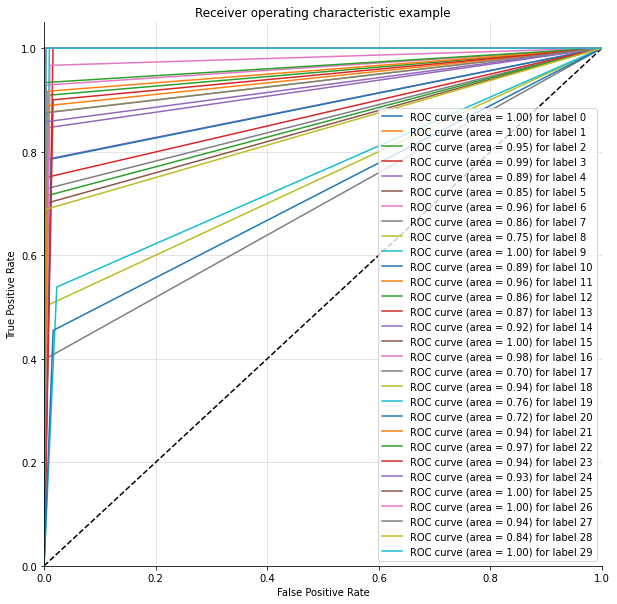

<Figure size 432x288 with 0 Axes>

In [26]:

plot_multiclass_roc(knn_gridcv, xtest, ytest, n_classes=30, figsize=(10, 10))

# KNN Confusion matrix

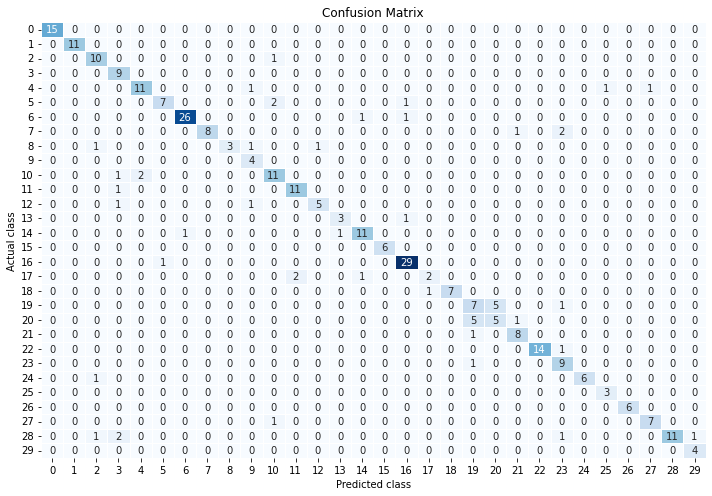

In [27]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_curve, auc
from matplotlib.colors import ListedColormap
import seaborn as sns
fig, ax1 = plt.subplots(1,1, figsize=(10, 7))
# Plot confusion matrix
ypred_knn = knn_gridcv.predict(xtest)
cm = confusion_matrix(ytest, ypred_knn)
sns.heatmap(cm, annot = True, cbar = False, fmt = "d", linewidths = .5, cmap = "Blues", ax = ax1)
ax1.set_title("Confusion Matrix")
ax1.set_xlabel("Predicted class")
ax1.set_ylabel("Actual class")
fig.tight_layout()

# svm using ResNet

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
  
# defining parameter range
param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000] }
  
grid_linear = GridSearchCV(SVC(kernel = 'linear'), param_grid, refit = True, verbose = 3,cv=10)
  
# fitting the model for grid search
grid_linear.fit(xtrain, ytrain)

# print best parameter after tuning
print(grid_linear.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid_linear.best_estimator_)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.907, total=   5.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s


[CV] .............................. C=0.01, score=0.907, total=   5.7s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.933, total=   5.6s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.933, total=   5.7s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.973, total=   5.7s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.932, total=   5.6s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.932, total=   5.7s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.919, total=   5.6s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.932, total=   5.7s
[CV] C=0.01 ..........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  5.7min finished


{'C': 0.01}
SVC(C=0.01, kernel='linear')


In [37]:
linear_max_test_accuracy = grid_linear.score(xtest, ytest)
print("Accuracy of linear SVM:", linear_max_test_accuracy)

Accuracy of linear SVM: 0.909375


# SVM CLASSIFICATION REPORT

In [38]:
ypred = grid_linear.predict(xtest)
print(classification_report(ytest,ypred))

                         precision    recall  f1-score   support

          abiesconcolor       1.00      1.00      1.00        15
      abiesnordmanniana       1.00      1.00      1.00        11
          acercampestre       0.83      0.91      0.87        11
            acerginnala       0.89      0.89      0.89         9
            acergriseum       0.81      0.93      0.87        14
            acernegundo       0.83      1.00      0.91        10
           acerpalmatum       0.93      0.96      0.95        28
      acerpensylvanicum       0.91      0.91      0.91        11
        acerplatanoides       1.00      0.67      0.80         6
     acerpseudoplatanus       0.80      1.00      0.89         4
             acerrubrum       0.86      0.86      0.86        14
        acersaccharinum       0.85      0.92      0.88        12
          acersaccharum       1.00      0.86      0.92         7
          aesculusflava       1.00      0.50      0.67         4
         aesculusglabra 

# ROC  SVM

In [39]:
def plot_multiclass_roc_svm(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()
    plt.savefig('resnet_knn_roc.png')


# confusion matrix SVM

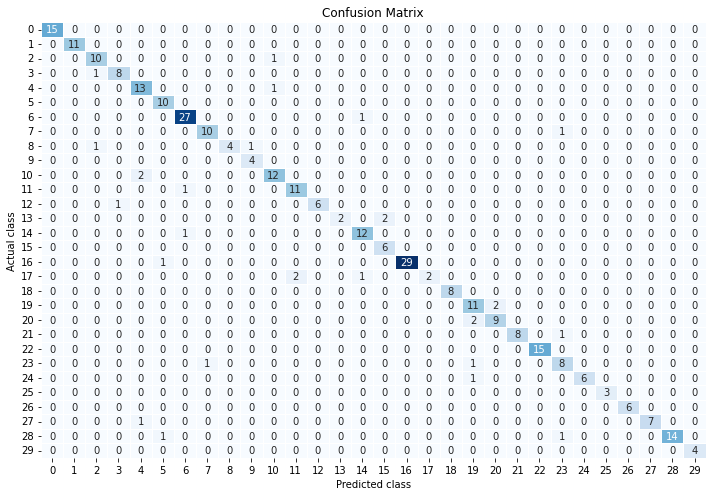

In [40]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_curve, auc
from matplotlib.colors import ListedColormap
import seaborn as sns
fig, ax1 = plt.subplots(1,1, figsize=(10, 7))
# Plot confusion matrix
cm = confusion_matrix(ytest, ypred)
sns.heatmap(cm, annot = True, cbar = False, fmt = "d", linewidths = .5, cmap = "Blues", ax = ax1)
ax1.set_title("Confusion Matrix")
ax1.set_xlabel("Predicted class")
ax1.set_ylabel("Actual class")
fig.tight_layout()

# Accuracy vs C SVM

Text(0, 0.5, 'Mean Test Score of training data')

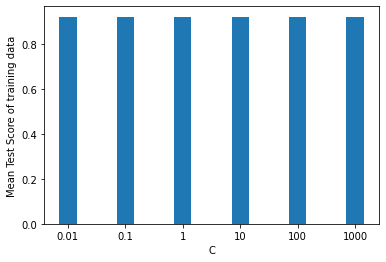

In [41]:
#bar plot for linear svm 
d1=[0.01,0.1, 1, 10, 100, 1000]
scores_linear =  grid_linear.cv_results_['mean_test_score']
x=[]
for i in range(len(d1)):
    x.append(str(d1[i]))
scores = list(scores_linear)
plt.bar(x, scores, width = 0.3)
plt.xlabel('C')
plt.ylabel('Mean Test Score of training data')

# ROC FOR SVM

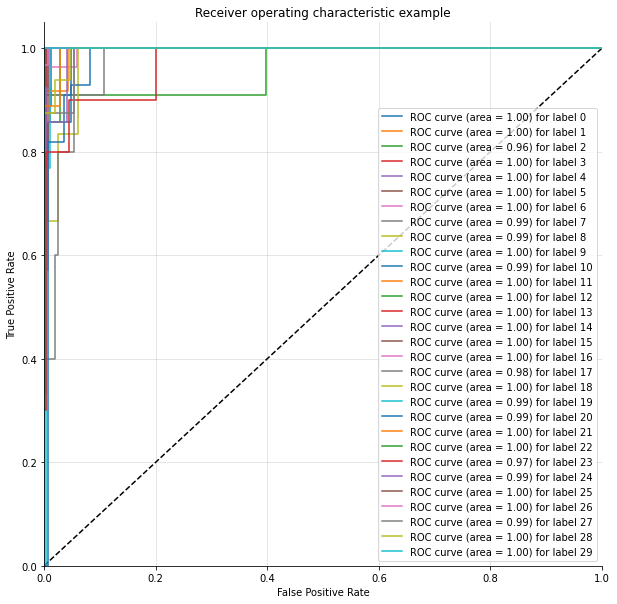

<Figure size 432x288 with 0 Axes>

In [43]:
plot_multiclass_roc_svm(grid_linear, xtest, ytest, n_classes=30, figsize=(10, 10))

# Converting Extracted Features to CSV file

In [ ]:
df_X_train = pd.DataFrame(xtrain)
df_X_test = pd.DataFrame(xtest)

df_Y_train = pd.DataFrame(ytrain)
df_Y_test = pd.DataFrame(ytest)